In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
import random
import seaborn as sns
from sklearn_pandas.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression

#from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Load data

In [2]:
df_approved = pd.read_csv('data/pf_approved_loan_data_nov.csv', index_col=False)
df_rejected = pd.read_csv('data/pf_rejected_loan_data_nov.csv', index_col=False)

## EDA

In [3]:
len(df_rejected)

2927

In [4]:
# Drop Innamed column

df_rejected = df_rejected.drop('Unnamed: 0', axis=1)
df_rejected.head()

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_amount,loan_requested,loan_borrowed_inc,loan_outstanding_inc,state,loan_id,status
0,952.00,0.0000,238.0,0.0000,0.0,0.0,0.000,180,5.0,1,...,0,0.0,0.0,200.0,200.0,0.0,0.0,"""CA""",FA112564-E6F2-4DF2-BE1C-008BEDAB2B53,0
1,0.00,0.0000,0.0,0.0000,0.0,0.0,0.000,0,0.0,0,...,1,9.0,0.0,500.0,500.0,0.0,0.0,"""UT""",9AC7920E-0809-4816-B9F4-6B7F8038F027,0
2,2095.94,0.0000,0.0,0.0000,0.0,0.0,523.985,9,3.0,1,...,0,0.0,0.0,300.0,300.0,0.0,0.0,"""WA""",3449E173-9ED9-43B7-9484-67ACABB8B806,0
3,7368.99,0.0000,5.0,1837.2475,0.0,0.0,0.000,177,5.5,3,...,1,0.0,0.0,255.0,255.0,0.0,0.0,"""CA""",7939A057-CC70-4F8C-91B4-5E88196C44DD,0
4,2178.57,311.1425,233.5,0.0000,0.0,0.0,0.000,54,18.5,2,...,1,0.0,0.0,250.0,250.0,0.0,0.0,"""WA""",452C00C5-965D-47BB-90F1-5F6BBE9F0B82,0


In [5]:
df_approved = df_approved.drop('Unnamed: 0', axis=1)
df_approved.head()

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_amount,loan_requested,loan_borrowed_inc,loan_outstanding_inc,state,loan_id,status
0,881.44,0.0,0.0,220.360,0.0,0.0000,0.0,174,2.166667,1,...,2,0.0,0.0,90.0,90.0,105.88,0.00,"""CA""",55132F51-0B41-45E1-B8E6-BE4F06EA159F,1
1,1612.38,0.0,0.0,346.845,0.0,56.2500,0.0,206,4.850000,2,...,2,0.0,0.0,100.0,255.0,117.65,0.00,"""CA""",B98E5B11-34CF-454B-92B3-E1666F528EF4,1
2,0.00,0.0,0.0,0.000,0.0,0.0000,0.0,0,0.000000,0,...,0,0.0,0.0,300.0,500.0,345.00,0.00,"""WA""",5396F154-EB2F-4D43-82BE-6735711FA3B2,1
3,1510.51,0.0,0.0,0.000,0.0,377.6275,0.0,16,2.000000,1,...,0,0.0,0.0,150.0,350.0,172.50,43.14,"""WA""",42F233D1-46A7-4E61-B935-17779A3B3814,0
4,620.00,0.0,155.0,0.000,0.0,0.0000,0.0,131,17.750000,5,...,0,0.0,0.0,100.0,500.0,115.00,57.50,"""WA""",982A81A9-C48D-447E-8C3E-8E86E00394A2,0


In [6]:
#How many loans were returned?

df_approved['status'].value_counts()

1    3317
0     828
Name: status, dtype: int64

In [7]:
#Are the 2 dataframes's columns similar?

df_rejected.columns == df_approved.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [8]:
#What are the columns in the dataframes?
df_approved.columns

Index(['monthly_income', 'gig_economy_weekly_income',
       'atm_check_deposits_weekly_income', 'direct_deposit_weekly_income',
       'government_aid_weekly_income', 'frequency_heuristic_weekly_income',
       'large_deposits_weekly_income', 'income_length', 'payrolls_per_month',
       'income_sources', 'days_since_most_recent_payroll',
       'days_until_next_payroll', 'bank_balance', 'overdraft_transactions',
       'nsf_transactions', 'return_transactions', 'reverse_transactions',
       'length_of_transaction_history', 'mortgage', 'auto_loan',
       'student_loan', 'traditional_single_payment', 'installment_loan',
       'predatory_installment_loan', 'title_loan', 'pay_advances',
       'total_loan_payments', 'no_of_other_active_loans',
       'traditional_single_payment_mean', 'traditional_single_payment_trend',
       'loan_amount', 'loan_requested', 'loan_borrowed_inc',
       'loan_outstanding_inc', 'state', 'loan_id', 'status'],
      dtype='object')

In [9]:
df_approved.shape

(4145, 37)

In [10]:
df_approved.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 0 to 4144
Data columns (total 37 columns):
monthly_income                       4145 non-null float64
gig_economy_weekly_income            4145 non-null float64
atm_check_deposits_weekly_income     4145 non-null float64
direct_deposit_weekly_income         4145 non-null float64
government_aid_weekly_income         4145 non-null float64
frequency_heuristic_weekly_income    4145 non-null float64
large_deposits_weekly_income         4145 non-null float64
income_length                        4145 non-null int64
payrolls_per_month                   4145 non-null float64
income_sources                       4145 non-null int64
days_since_most_recent_payroll       4145 non-null int64
days_until_next_payroll              4145 non-null int64
bank_balance                         4145 non-null float64
overdraft_transactions               4145 non-null int64
nsf_transactions                     4145 non-null int64
return_transactions 

There are no null values and all essential data is numeric, which helps a lot with the analysis process.

In [11]:
df_rejected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 37 columns):
monthly_income                       2927 non-null float64
gig_economy_weekly_income            2927 non-null float64
atm_check_deposits_weekly_income     2927 non-null float64
direct_deposit_weekly_income         2927 non-null float64
government_aid_weekly_income         2927 non-null float64
frequency_heuristic_weekly_income    2927 non-null float64
large_deposits_weekly_income         2927 non-null float64
income_length                        2927 non-null int64
payrolls_per_month                   2927 non-null float64
income_sources                       2927 non-null int64
days_since_most_recent_payroll       2927 non-null int64
days_until_next_payroll              2927 non-null int64
bank_balance                         2927 non-null float64
overdraft_transactions               2927 non-null int64
nsf_transactions                     2927 non-null int64
return_transactions 

There are null values only in 'state' column. Essential data is numeric

In [12]:
df_rejected.state.value_counts()

"WA"    1531
"CA"     657
"UT"     506
"ID"     130
"TX"       3
"AZ"       2
"TN"       1
"MA"       1
"OK"       1
"CO"       1
"MT"       1
"WI"       1
Name: state, dtype: int64

In [13]:
df_approved.state.value_counts()

"WA"    2334
"CA"    1131
"UT"     569
"ID"     108
"KS"       1
"FL"       1
"GA"       1
Name: state, dtype: int64

In [14]:
#localize rows where state is missing
df_rejected.loc[df_rejected.state.isnull()]

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_amount,loan_requested,loan_borrowed_inc,loan_outstanding_inc,state,loan_id,status
15,786.00,0.0,0.000,0.0000,196.50,0.0000,0.0000,131,1.250000,1,...,0,0.000000,0.000000e+00,150.0,150.0,0.0,0.0,NaN,DB86BA08-82D6-4831-BFDF-4D1DC8ADA01B,0
96,0.00,0.0,0.000,0.0000,0.00,0.0000,0.0000,0,4.500000,2,...,3,0.000000,0.000000e+00,500.0,500.0,0.0,0.0,NaN,FA06D4A6-D630-40A9-9285-27BF5369C421,0
163,3602.01,0.0,25.000,875.5025,0.00,0.0000,0.0000,291,6.363636,2,...,3,1.900000,-9.090909e-02,500.0,500.0,0.0,0.0,NaN,254AA4D0-E504-4C4D-BAFC-7D4225BB390F,0
256,1159.81,0.0,0.000,289.9525,0.00,0.0000,0.0000,146,1.833333,1,...,1,0.000000,0.000000e+00,300.0,300.0,0.0,0.0,NaN,5C3CDF46-053D-4D6F-B31D-559528F3828D,0
348,0.00,0.0,0.000,0.0000,0.00,0.0000,0.0000,0,3.000000,1,...,3,0.000000,0.000000e+00,500.0,500.0,0.0,0.0,NaN,72E0396F-3A0F-44EA-8676-59C44CC61FAC,0
378,2275.90,0.0,37.500,531.4750,0.00,0.0000,0.0000,306,3.077778,2,...,2,1.500000,1.635220e-01,300.0,300.0,0.0,0.0,NaN,FCBF7A0A-BBAC-47EF-B81B-3E721434C6F3,0
382,862.82,0.0,0.000,215.7050,0.00,0.0000,0.0000,98,2.000000,1,...,0,0.000000,0.000000e+00,200.0,500.0,0.0,0.0,NaN,529C92D5-92C6-466C-8DA7-E0884FB6F2F0,0
408,978.26,0.0,244.565,0.0000,0.00,0.0000,0.0000,4,2.666667,2,...,4,0.000000,0.000000e+00,300.0,300.0,0.0,0.0,NaN,D30871BC-27F0-4E15-8383-EBD2FD66DF32,0
430,2308.00,0.0,201.250,0.0000,375.75,0.0000,0.0000,59,3.000000,2,...,2,0.000000,0.000000e+00,500.0,500.0,0.0,0.0,NaN,646F4CB6-8072-408B-BB68-D5A350C02076,0
466,32.00,0.0,8.000,0.0000,0.00,0.0000,0.0000,0,0.000000,0,...,1,0.000000,0.000000e+00,350.0,350.0,0.0,0.0,NaN,27475384-809A-486B-8161-03AE6BD4AD29,0


# Working with approved transactions

## Correlations heatmap

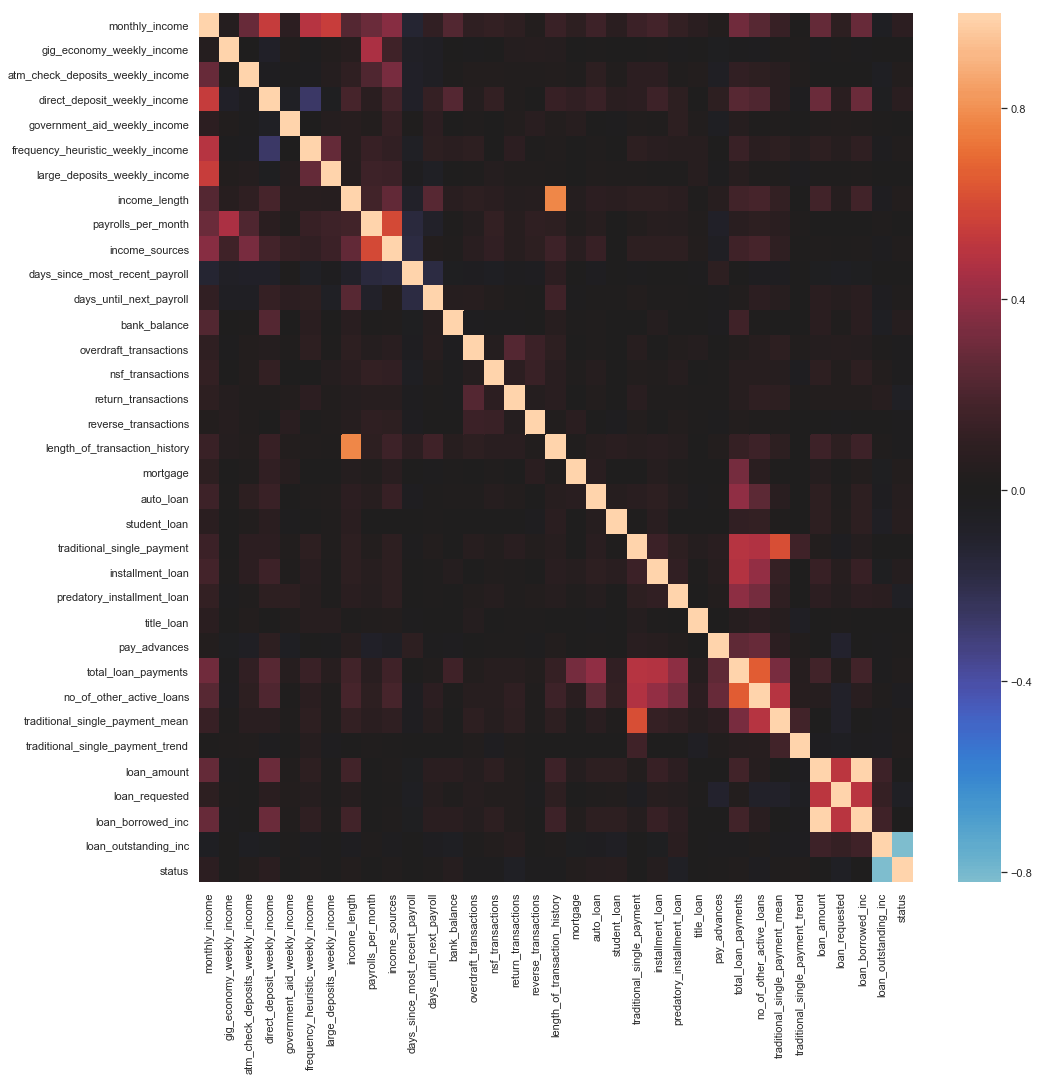

In [15]:
sns.set(rc={'figure.figsize':(16,16)})
sns.heatmap(df_approved.corr(), center=0);

It is clear that there is some data that reflects event after granting the loan ('loan_amount', 'loan_borrowed', etc.).

There is also hight correlations between length of income and length of transaction history, which asre clearly connected. There are also some intuitive correlations that will be corrected later.

## Check data distributions

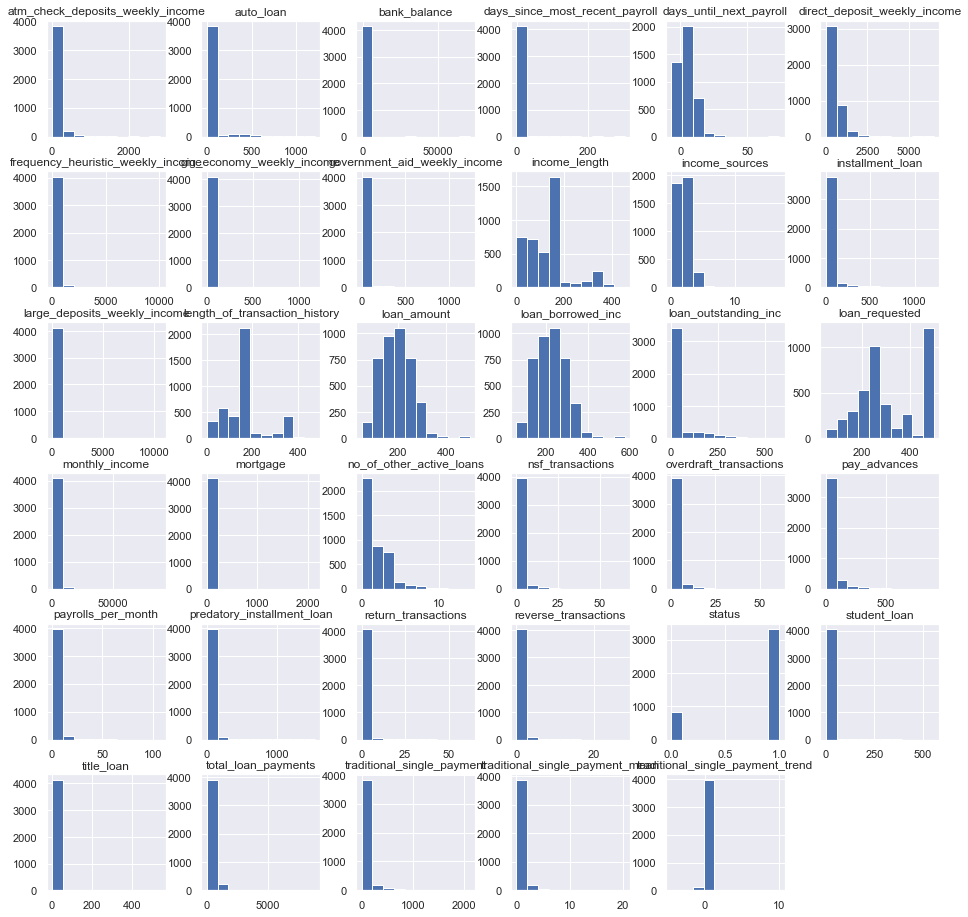

In [16]:
df_approved.hist();
    

In [17]:
df_approved['student_loan'].value_counts()

0.00      4020
50.00        9
10.00        3
5.00         2
100.00       2
200.00       2
31.50        1
253.18       1
64.73        1
83.19        1
157.77       1
50.70        1
52.50        1
6.11         1
87.73        1
14.70        1
106.77       1
123.23       1
260.20       1
95.99        1
231.00       1
250.14       1
17.19        1
106.74       1
319.58       1
286.42       1
128.35       1
117.75       1
32.25        1
148.02       1
          ... 
219.83       1
80.70        1
67.38        1
38.45        1
20.37        1
92.52        1
90.78        1
80.19        1
113.58       1
57.46        1
113.94       1
264.90       1
557.35       1
145.32       1
56.17        1
77.02        1
119.38       1
196.42       1
129.24       1
85.80        1
115.70       1
286.07       1
260.79       1
20.85        1
92.58        1
99.82        1
79.79        1
166.42       1
125.01       1
190.72       1
Name: student_loan, Length: 113, dtype: int64

## Data cleaning

### 1. Drop columns asocciated with granting the loan: loan_amount, loan_borrowed_inc, loan_outstanding_inc, loan_id

In [18]:
df_approved = df_approved.drop(['loan_amount', 'loan_borrowed_inc', 'loan_outstanding_inc', 'loan_id' ], axis=1)

### 2. Convert states in categories

In [19]:
state_values = list(df_approved.state.values) + list(df_rejected.state.values)
state_values = list(set(state_values))

In [20]:
# create a dictionsry with values
i = 0
values_dict = {}
for value in state_values:
    values_dict[value] = i
    i += 1

In [21]:
# create a custom function that substitutes state with number
def state_number(state):
    try:
        for key, value in values_dict.items():
            if state == key:
                return value
    except:
        return 0

In [22]:
#substiture dtate codes with numbers

df_approved.state = df_approved.state.apply(state_number)

### 3. One-hot-encoding: states

In [23]:
states_category = df_approved['state'].values.reshape(-1, 1)

In [24]:
encoder = OneHotEncoder(drop='first', categories='auto').fit(states_category)

In [25]:
encoder.categories_

[array([ 1,  3,  4,  9, 11, 12, 15])]

In [26]:
encoder.get_feature_names(["state"])

array(['state_3', 'state_4', 'state_9', 'state_11', 'state_12',
       'state_15'], dtype=object)

In [27]:
ohe = pd.DataFrame(encoder.transform(states_category).toarray(),
                   columns=encoder.get_feature_names(["state"]))

In [28]:
ohe.columns

Index(['state_3', 'state_4', 'state_9', 'state_11', 'state_12', 'state_15'], dtype='object')

In [29]:
df_approved = df_approved.drop(["state"], axis=1)

In [30]:
df_approved = pd.concat([df_approved, ohe], axis=1, join='inner')

In [31]:
df_approved.head()

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,traditional_single_payment_mean,traditional_single_payment_trend,loan_requested,status,state_3,state_4,state_9,state_11,state_12,state_15
0,881.44,0.0,0.0,220.360,0.0,0.0000,0.0,174,2.166667,1,...,0.0,0.0,90.0,1,0.0,0.0,0.0,0.0,1.0,0.0
1,1612.38,0.0,0.0,346.845,0.0,56.2500,0.0,206,4.850000,2,...,0.0,0.0,255.0,1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.00,0.0,0.0,0.000,0.0,0.0000,0.0,0,0.000000,0,...,0.0,0.0,500.0,1,0.0,0.0,1.0,0.0,0.0,0.0
3,1510.51,0.0,0.0,0.000,0.0,377.6275,0.0,16,2.000000,1,...,0.0,0.0,350.0,0,0.0,0.0,1.0,0.0,0.0,0.0
4,620.00,0.0,155.0,0.000,0.0,0.0000,0.0,131,17.750000,5,...,0.0,0.0,500.0,0,0.0,0.0,1.0,0.0,0.0,0.0


## Approved loans: train test split
I will work mainly with approved loans in the beginning and use rejected loans a another testing set

 To do:
- substitute with numerical and one hot encoding
- one hot encoding states
- remove columns that reflect something after the loan was made

In [32]:
random.seed(112)
y = df_approved['status']
X = df_approved.drop(['status'], axis = 1)

#to maintain time order of the appointment date, shuffle is set to False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [112]:
#mapper = DataFrameMapper([
#    (['state'], OneHotEncoder(drop='first')),
#    ([''], # choose columns to )
#])

### FSM: Logistic regression

In [44]:
pipe = Pipeline(steps=[
    #('mapper', mapper),
    ('classifier', LogisticRegression(solver='lbfgs'))
])

In [45]:
pipe.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [46]:
print("Report:")
y_true, y_pred = y_test, pipe.predict(X_test)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
              precision    recall  f1-score   support

           0       0.33      0.01      0.02       160
           1       0.81      0.99      0.89       669

    accuracy                           0.80       829
   macro avg       0.57      0.50      0.46       829
weighted avg       0.72      0.80      0.72       829



array([[  2, 158],
       [  4, 665]])

In [47]:
LR_score = cross_val_score(pipe, X_test, y_test, cv=5)
print('\nEach Cross Validated Accuracy score: \n', LR_score)
print("\nOverall Logistic Regression Accuracy: %0.2f (+/- %0.2f)\n" % (LR_score.mean(), LR_score.std() * 2))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Each Cross Validated Accuracy score: 
 [0.80120482 0.80722892 0.78915663 0.77108434 0.8       ]

Overall Logistic Regression Accuracy: 0.79 (+/- 0.03)



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
